# Test Cellpose model on new unlabeled cell data


Test data consists of one sample with 10 resolution levels (100%-10% in 10% intervals) and 3 imaging modes (reflection, transmission, and scattering)

## Code Credits and Implementation Details



1.  Stringer et al. Foundational structure + save_masks + outputs: https://github.com/MouseLand/cellpose?tab=readme-ov-file, Cellpose Team. Cellpose Code. Available at: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/runcellpose2.ipynb.



Remaining authors implementation: dynamic diameter adjustment, process_images(), get_diameter_for_image(), calculate_diameter(), check image dimensions and convertion

## Installation

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
albumentations 1.4.20 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 9.6 MB/s eta 0:00:00


Check CUDA version and that GPU is working in cellpose and import other libraries.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
from skimage.measure import label
from skimage.segmentation import relabel_sequential
import numpy as np
import csv
from astropy.visualization import simple_norm
from ipywidgets import interact
import pandas as pd
from tabulate import tabulate

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Dec 31 21:06:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  7

## Mount google drive

Please mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels, either `_seg.npy` files from the cellpose gui, or `_masks.tif` files.

In [3]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## Parameters

In [4]:
# model name and path

#@markdown ###Custom model path (full path):

model_path = "/content/gdrive/MyDrive/CELLPOSE//content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/train/models/malaria" #@param {type:"string"}

#@markdown ###Path to images:

dir = "/content/gdrive/MyDrive/CELLPOSE/dataset_11/test" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "None" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  45#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


In [5]:
import math

# Predefined mapping of dimensions to diameters
dimension_to_diameter = {
    "1200x1600": 45,
    "120x160": 4.5,
    "240x320": 9.0,
    "360x480": 13.5,
    "480x640": 18.0,
    "600x800": 22.5,
    "720x960": 27.0,
    "840x1120": 31.5,
    "960x1280": 36.0
}

# Function to calculate the diameter for unknown dimensions
def calculate_diameter(height, width):
    # Use a proportional constant based on a known reference dimension
    reference_key = "1200x1600"
    reference_diameter = dimension_to_diameter[reference_key]
    reference_height, reference_width = map(int, reference_key.split('x'))

    # Calculate the diagonal of the reference dimension and the given dimension
    reference_diagonal = math.sqrt(reference_height**2 + reference_width**2)
    given_diagonal = math.sqrt(height**2 + width**2)

    # Scale the diameter proportionally
    return (given_diagonal / reference_diagonal) * reference_diameter

# Function to determine the diameter based on image dimensions
def get_diameter_for_image(image, dimension_to_diameter):
    height, width = image.shape[:2]
    dimension_key = f"{height}x{width}"
    if dimension_key in dimension_to_diameter:
        return dimension_to_diameter[dimension_key]
    else:
        # Calculate the diameter for unknown dimensions
        return calculate_diameter(height, width)



## run custom model


In [6]:
# Gets image files in the directory (ignoring files ending with _masks)
files = io.get_image_files(dir, '_masks')

print(files)
images = [io.imread(f) for f in files]
len(images)

# Check dimensions and convert if necessary
conv_images = []
for i, img in enumerate(images):
    shape = img.shape
    if len(shape) == 3:  # Image has three dimensions
        if shape[0] == 3:  # Channels are in the first position (C, H, W)
            print(f"Image {i} ({files[i]}) has shape {shape}: Converting from C, H, W to H, W, C")
            img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C)
        elif shape[-1] == 3:  # Channels are already in the last position (H, W, C)
            print(f"Image {i} ({files[i]}) has shape {shape}: No conversion needed")
        else:
            print(f"Image {i} ({files[i]}) has shape {shape}: Unexpected channel arrangement")
            continue  # Skip images with unexpected dimensions
    elif len(shape) == 2:  # Image has two dimensions (grayscale)
        print(f"Image {i} ({files[i]}) has shape {shape}: Converting grayscale to H, W, C with a single channel")
        img = np.expand_dims(img, axis=-1)  # Add a channel dimension
    else:
        print(f"Image {i} ({files[i]}) has an unexpected shape: {shape}. Skipping...")
        continue  # Skip images with unexpected dimensions

    conv_images.append(img)  # Save the converted image

print(f"Total converted images: {len(conv_images)}")


['/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R.tiff', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_1.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_2.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_3.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_4.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_5.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_6.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_7.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_8.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_R_res0_9.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_S.tiff', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_S_res0_1.tif', '/content/gdrive/MyDrive/CELLPOSE/dataset_11/test/T07_Sample1_S_res0_2.tif', '/content/

In [7]:
images = conv_images
# Declare the model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# Use model diameter if user-specified diameter is 0
diameter = model.diam_labels if diameter == 0 else diameter

# Collect results
masks = []   # List of generated masks
flows = []   # List of flow data
diams = []   # List of diameters used

for i, img in enumerate(images):
    height, width = img.shape[:2]
    # Determine the appropriate diameter based on the dimensions
    diameter = get_diameter_for_image(img, dimension_to_diameter)
    print(f"Processing image {i+1}/{len(images)} with dimensions: {height}x{width} pixels, diameter: {diameter} pixels")

    # Run the model
    masks_result, flows_result, styles_result = model.eval([img],
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )
    masks.append(masks_result[0])       # Add the mask to the list
    flows.append(flows_result[0])       # Add flow data to the list
    diams.append(diameter)              # Add the diameter used


100%|██████████| 25.3M/25.3M [00:03<00:00, 8.79MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

Processing image 1/30 with dimensions: 1200x1600 pixels, diameter: 45 pixels
Processing image 2/30 with dimensions: 120x160 pixels, diameter: 4.5 pixels
Processing image 3/30 with dimensions: 240x320 pixels, diameter: 9.0 pixels
Processing image 4/30 with dimensions: 360x480 pixels, diameter: 13.5 pixels
Processing image 5/30 with dimensions: 480x640 pixels, diameter: 18.0 pixels
Processing image 6/30 with dimensions: 600x800 pixels, diameter: 22.5 pixels
Processing image 7/30 with dimensions: 720x960 pixels, diameter: 27.0 pixels
Processing image 8/30 with dimensions: 840x1120 pixels, diameter: 31.5 pixels
Processing image 9/30 with dimensions: 960x1280 pixels, diameter: 36.0 pixels
Processing image 10/30 with dimensions: 1080x1440 pixels, diameter: 40.5 pixels
Processing image 11/30 with dimensions: 1200x1600 pixels, diameter: 45 pixels
Processing image 12/30 with dimensions: 120x160 pixels, diameter: 4.5 pixels
Processing image 13/30 with dimensions: 240x320 pixels, diameter: 9.0 pi

## save output to *_seg.npy


In [8]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=np.array(diams),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [9]:
inverted = True # for Reflection and Scattering

In [10]:
if inverted:
  # Transform and normalize images
  def process_images(images):
      processed_images = []
      for img in images:
          # Transform if channels are in the first dimension
          if img.shape[0] == 3 and img.ndim == 3:
              img = img.transpose(1, 2, 0)  # Convert to (height, width, channels)

          # Normalize image data
          if img.dtype != np.uint8:
              img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0–1
              img = (img * 255).astype(np.uint8)  # Scale to 0–255

          processed_images.append(img)
      return processed_images

  # Transform and normalize the images
  processed_images = process_images(images)
  # Save transformed and normalized images along with masks and flows
  io.save_masks(processed_images,  # Use processed images
                masks,
                flows,
                files,
                channels=[chan, chan2],
                png=True,  # Save masks as PNG files
                tif=False,  # Do not save masks as TIFF files
                save_txt=True,  # Save outlines as TXT files for ImageJ
                save_flows=False,  # Do not save flow data
                save_outlines=False,  # Do not save outlines
                save_mpl=True  # Create Matplotlib figures for visualization
                )
else:
  # Save the original images along with masks and flows
  io.save_masks(images,
                masks,
                flows,
                files,
                channels=[chan, chan2],
                png=True,  # Save masks as PNG files and an example image
                tif=False,  # Do not save masks as TIFF files
                save_txt=True,  # Save outlines as TXT files for ImageJ
                save_flows=False,  # Do not save flow data
                save_outlines=False,  # Do not save outlines
                save_mpl=True  # Create Matplotlib figures for visualization (WARNING: SLOW WITH LARGE IMAGES)
                )


(-0.5, 3599.5, 899.5, -0.5)

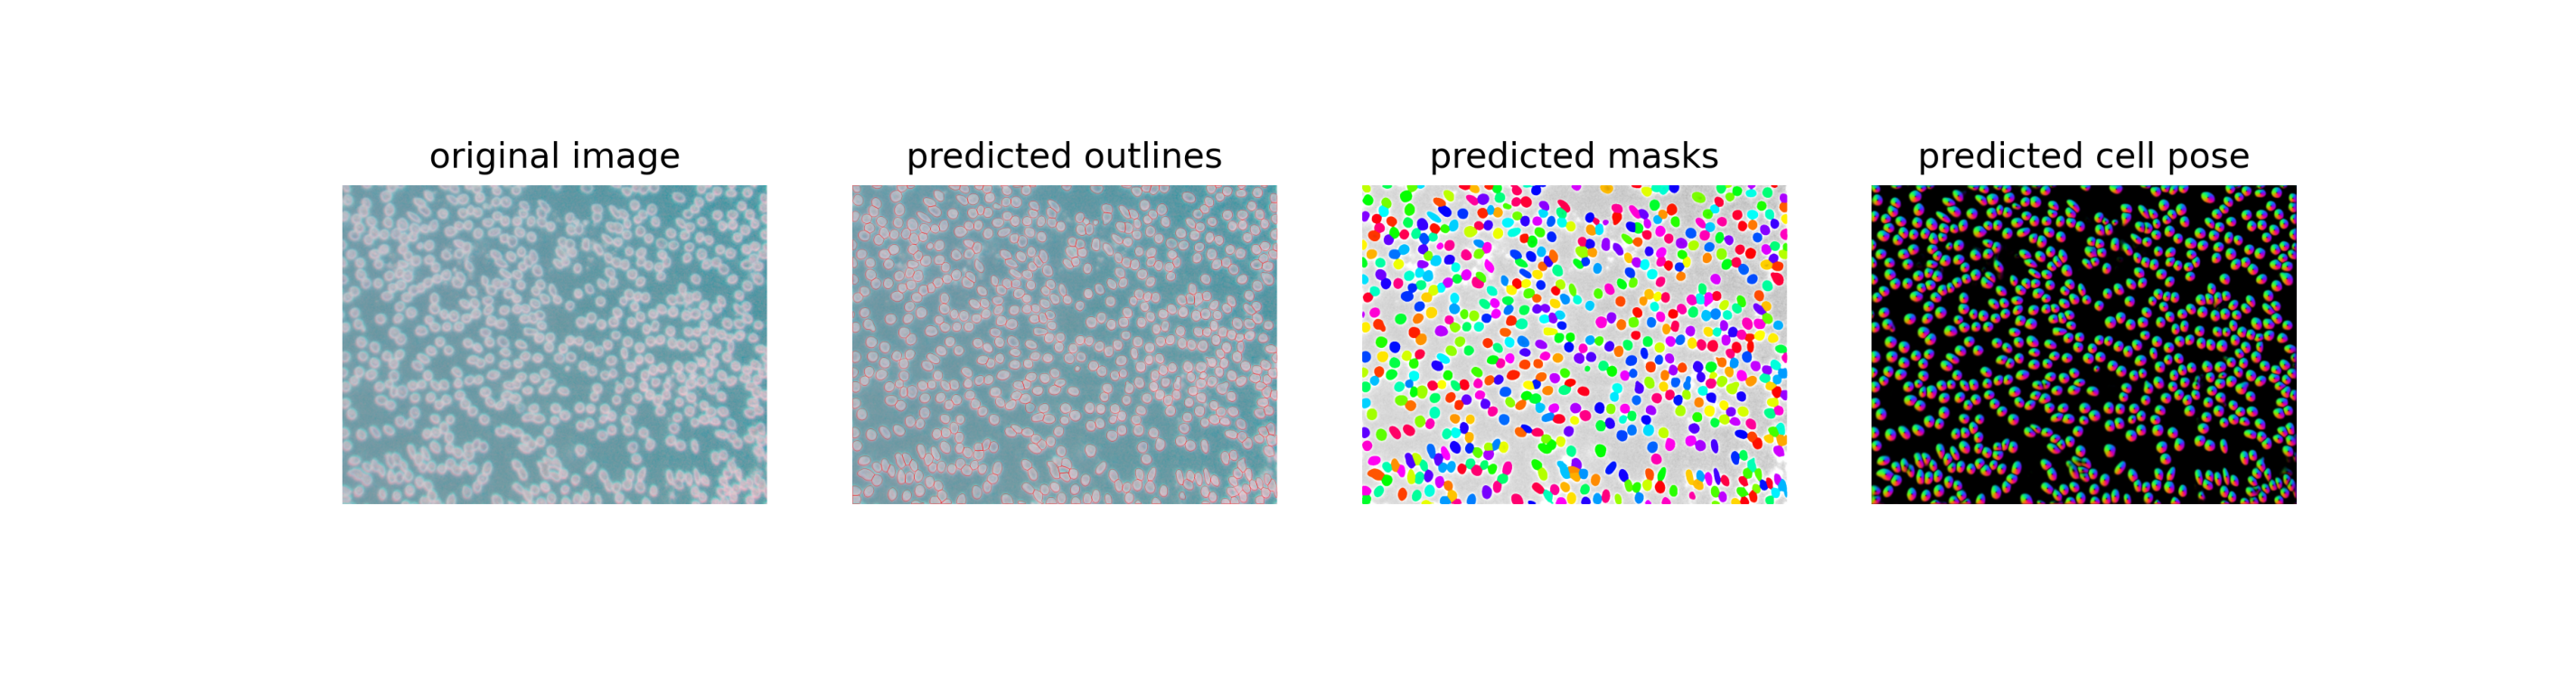

In [11]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')

Remaining authors implementation: Adaptation of quality control metrics code (Dice Score, Panoptic Score etc.), Extension (Dice Score) in stardist/matching.py, get_diameter_for_image(), calculate_dice(), calculate_diameter(), all matplot plots in visualization chapter